## Tarea 3 - Métodos de Aprendizajes de Máquinas en Data Science

### Integrantes: Sofía Álvarez, Sebastián Dinator.

### Importación de librerías y datos

In [1]:
import pandas as pd
import numpy as np
from sympy import Matrix
import re
import string
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

# k-fold cross validation
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold

# Modelos
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics as mt

import matplotlib.pyplot as plt

In [2]:
# Se cargan los datos
train_data = pd.read_csv('train_tweets.csv') # Entrenamiento
test_data = pd.read_csv('test_tweets.csv') # Clasificar

In [3]:
# Mostrando la data
display(train_data.head(6))
print(train_data.shape)
print('# id =', len(train_data['tweet_id'].unique()))

display(test_data.head(6))
print(test_data.shape)
print('# id =', len(test_data['tweet_id'].unique()))



,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0
5,1233127781707333632,Ana Maraca culia #Los80,1


(2256, 3)
# id = 2256


,tweet_id,text
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c..."
4,1399515878727749632,@beudalgoaj puta merda
5,1533854418835189760,@aitana_atenea Puto hermoso cuerpazo 🤗🥰👌🏼


(2291, 2)
# id = 2291


### Hay tantos id cómo filas, así que no es significativo usar la variable para entrenar los modelos. 

In [4]:
# Analizando la variable Odio
train_data['Odio'].unique()

array([0, 1], dtype=int64)

In [5]:
print(f'Hay {train_data.Odio.isnull().sum()} datos nulos en Odio')
print(f'Hay {train_data.text.isnull().sum()} datos nulos en text')

Hay 0 datos nulos en Odio
Hay 0 datos nulos en text


### No hay nulos, por lo que ninguna fila se elimina.
### A continuación, se cuentan las palabras por tweet para entender mejor los datos:

Hay un mínimo de 1 palabras
Hay un máximo de 86 palabras


<Axes: ylabel='Frequency'>

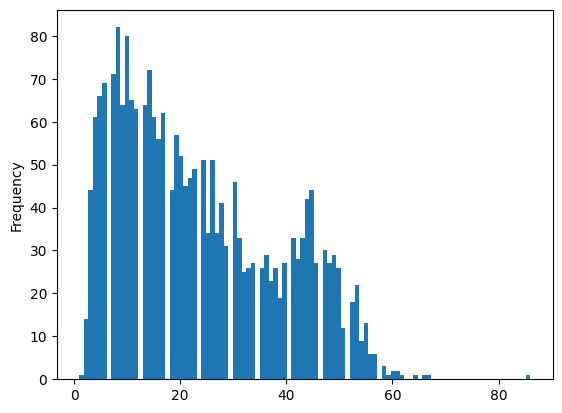

In [6]:
words_count = train_data.text.str.split().apply(len) # Contando palabras
print(f'Hay un mínimo de {words_count.min()} palabras')
print(f'Hay un máximo de {words_count.max()} palabras')
words_count.plot(kind="hist", bins=100)

### Viendo cuáles son los extremos: (solo hay 1 tweet para cada valor)

In [7]:
print('Tweet con 1 palbra:')
display(train_data.iloc[list(words_count).index(min(list(words_count)))].text)

print('Tweet con 86 palabras:')
pd.set_option('display.max_colwidth', None)
display(train_data.iloc[list(words_count).index(max(list(words_count)))].text)


Tweet con 1 palbra:


'Puta'

Tweet con 86 palabras:


'@vanev87 @OvMyriam @JaraDiana @MariteZann @luzmatto @yi_yi46 @karinaottazu @VictorRamnGonz3 @e_guata @LuisRob68054970 @marlepy @JuanFer79484046 @SheyShey76 @ledmp @gonzalez_justo @dario_ee @arquiferrari @71Elvis @CespedesBea @GessyCazal @Rocio_La_Negra @MelisseDi @RamonMPoletti @adiazarce @DardoCastelluc2 @MarParedes_08 @Eliyeg @mafaldita_90 @analaufernan @Carlosled1951 @Aleja92209724 @AngelicaZunilda @antomartinez87 @bea_dtj @Cuchicho @Akcv @Yoyi_aponte @jose369100 @piralaguna @lucho15colman @transporte2012 @neida_aquino @escuelazurda @mximo10meridio1 Hilanderos calentamiento!! Estamos a horitas de despedir un año y recibir a otro con esperanzas, sueños y anhelos renovados! Deseo para todos ustedes un bendecido año y para todos los q vivimos en este dulce pais que Marito sea menos desastre!!😂😂 https://t.co/d7B34Dt74n'

### Se analiza la distribución de percentiles

In [8]:
words_count.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    2256.000000
mean       23.355940
std        14.893758
min         1.000000
25%        11.000000
50%        20.000000
75%        35.000000
80%        39.000000
85%        43.000000
90%        46.000000
95%        50.000000
max        86.000000
Name: text, dtype: float64

In [9]:
# Se revisaron los tweet con más de 46 palabras pero no se encontró nada significativo
#pd.set_option('display.max_colwidth', None)
#display(train_data.iloc[[indice for indice, valor in enumerate(words_count) if valor == 46]].text)


### Limpieza de datos
* Eliminando emojis

In [10]:
train_data['text'] = train_data['text'].apply(lambda s: emoji.replace_emoji(s, ''))
display(train_data.head(6))

#test_data['text'] = test_data['text'].apply(lambda s: emoji.replace_emoji(s, ''))
#display(test_data.head(6))

,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que siempre es así lskdkdnff https://t.co/813bPNQZqR,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA DE MIERDVA,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca jajajajjajajajajja siempre d negro,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi https://t.co/JtJixcR5kK,1
4,1533854824378290176,"#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nSector: Norte, Autopista, a la altura del puente que une Samborondon con Sauces\r\nSexo: Macho.\r\nRaza: Doberman Pinscher.\r\nObsv.: Negro con beige.\r\nContacto: 0967948036\r\n¡Ayúdalo volver con su familia!\r\n#AlertaMePerdí https://t.co/D3IHyKxUCU",0
5,1233127781707333632,Ana Maraca culia #Los80,1


* Función para limpiar los tweets

In [11]:
def clean_tweet(tweet):
    #tweet = tweet.lower() # Convertir a minúsculas (dejar??)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # Eliminar URLs
    tweet = re.sub(r'@\w+', '', tweet) # Eliminar menciones de usuario
    tweet = re.sub(r'#\w+', '', tweet) # Eliminar hashtags
    tweet = re.sub(r'\d+', '', tweet) # Eliminar números
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # Eliminar puntuaciones
    tweet = re.sub(r'\\r\\n|\\n|\\r', ' ', tweet) # Eliminar caracteres especiales
    tweet = re.sub(r'\s+', ' ', tweet).strip() # Eliminar espacios adicionales
    tweet = re.sub(r'[¿¡]', '', tweet) # Eliminar ¿ y ¡
    
    return tweet

In [12]:
# Aplicando función de limpieza
train_data['cleaned_text'] = train_data['text'].apply(clean_tweet)
#test_data['cleaned_text'] = test_data['text'].apply(clean_tweet)

display(train_data.head(6))
#display(test_data.head(6))

,tweet_id,text,Odio,cleaned_text
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que siempre es así lskdkdnff https://t.co/813bPNQZqR,0,En una amistad o soy tipo Lo peor es que siempre es así lskdkdnff
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA DE MIERDVA,1,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA DE MIERDVA
2,1079889645280944129,menos mal q se recibe el año con ropa blanca jajajajjajajajajja siempre d negro,0,menos mal q se recibe el año con ropa blanca jajajajjajajajajja siempre d negro
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi https://t.co/JtJixcR5kK,1,Cuantos INFILTRADOS extranjeros hay ahi
4,1533854824378290176,"#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nSector: Norte, Autopista, a la altura del puente que une Samborondon con Sauces\r\nSexo: Macho.\r\nRaza: Doberman Pinscher.\r\nObsv.: Negro con beige.\r\nContacto: 0967948036\r\n¡Ayúdalo volver con su familia!\r\n#AlertaMePerdí https://t.co/D3IHyKxUCU",0,Fecha Sector Norte Autopista a la altura del puente que une Samborondon con Sauces Sexo Macho Raza Doberman Pinscher Obsv Negro con beige Contacto Ayúdalo volver con su familia
5,1233127781707333632,Ana Maraca culia #Los80,1,Ana Maraca culia


### Viendo la nueva cantidad de palabras por tweet

Hay un mínimo de 1 palabras
Hay un máximo de 62 palabras


<Axes: ylabel='Frequency'>

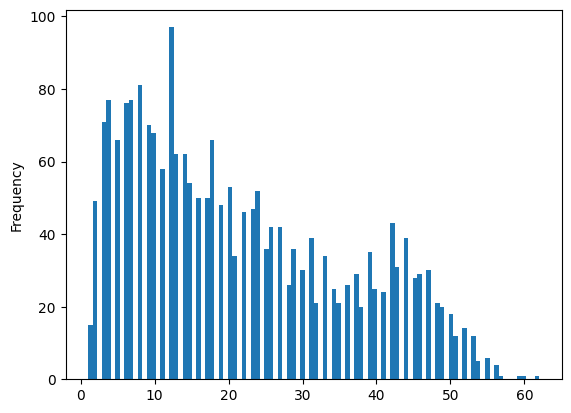

In [13]:
words_count = train_data.cleaned_text.str.split().apply(len) # Contando palabras
print(f'Hay un mínimo de {words_count.min()} palabras')
print(f'Hay un máximo de {words_count.max()} palabras')
words_count.plot(kind="hist", bins=100)

### Los tweets se convierten a vector para poder aplicar los modelos numéricos:
#### Nota: se probó con CountVectorizer() pero se obtiene peor score.

In [14]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_data.iloc[:, 3]) # Transformando los tweets a vector
print(f'Ahora hay {X_train.shape[1]} variables')

y_train = train_data.iloc[:,2] # Obteniendo la variable Odio a predecir


Ahora hay 9899 variables


### La cantidad de variables del nuevo set de datos no es preocupante, ya que ninguno de los modelos a usar (SVM, NB, arbol de decisón) se ve afectado por la maldición de la dimensionalidad.

* Función para generar k-fold y calcular F1-score total del modelo

In [15]:
def kfold(modelo):
    
    lista_return = [] # Lista que retornará 2 mean y 2 std, uno para cada valor de k.
    
    for K in range(4,6,1):  # Se decide probar con dos valores de K. 
                            # K = 4 -> split 75% - 25% (564 datos)
                            # K = 5 -> split 80% - 20% (451 datos)
                
        # Lista con los f1-score de cada iteración de k-fold
        resultado = cross_val_score(modelo, X_train, y_train, cv = K, scoring='f1') 
        
        print(f'K = {K}: {np.mean(resultado):.3f} +- {np.std(resultado):.3f}')
        
        lista_return.append(round(np.mean(resultado), 3))
        lista_return.append(round(np.std(resultado), 3))
        
    return lista_return

* Función para graficar

In [16]:
def graficar(datos, values, titulo, var_y, var_x, y_min, y_max, ancho, alto):
    
    mean_scores_4 = [datos[i][0] for i in range(0,len(datos),1)] # Mean para K = 4
    std_scores_4 = [datos[i][1] for i in range(0,len(datos),1)]  #  Std para K = 4
    mean_scores_5 = [datos[i][2] for i in range(0,len(datos),1)] # Mean para K = 5
    std_scores_5 = [datos[i][3] for i in range(0,len(datos),1)]  #  Std para K = 5
    
    plt.figure(figsize=(ancho, alto))
    plt.plot(values, mean_scores_4, label = 'mean k = 4', color='red')
    plt.plot(values, [x + y for x, y in zip(mean_scores_4, std_scores_4)], label = 'std k = 4', color='black')
    plt.plot(values, [x - y for x, y in zip(mean_scores_4, std_scores_4)], color='black')
    plt.plot(values, mean_scores_5, label = 'mean k = 5', color='orange')
    plt.plot(values, [x + y for x, y in zip(mean_scores_5, std_scores_5)], label = 'std k = 5', color='blue')
    plt.plot(values, [x - y for x, y in zip(mean_scores_5, std_scores_5)], color='blue')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(titulo)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.show()
    
    

# SVM

### Para escoger el mejor modelo de Support Vector Machine, primero se analizarán todos los tipos de kernel para saber cuál se ajusta a los datos y 2 valores extremos de C.

#### Considerando el dilema sesgo-varianza, se espera que los modelos con C = 999 (modelo complejo) tengan mejor F1-score que los C = 1 (modelo sencillo).

Modelo: kernel LINEAR y C = 1
K = 4: 0.782 +- 0.012
K = 5: 0.783 +- 0.013
Modelo: kernel LINEAR y C = 999
K = 4: 0.745 +- 0.026
K = 5: 0.735 +- 0.019


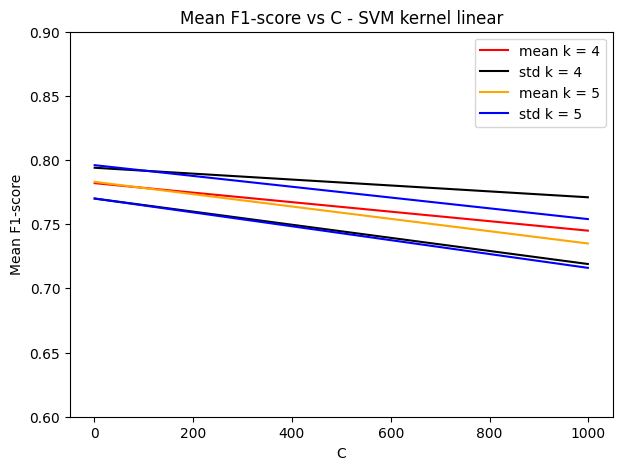

Modelo: kernel POLY y C = 1
K = 4: 0.736 +- 0.002
K = 5: 0.738 +- 0.003
Modelo: kernel POLY y C = 999
K = 4: 0.737 +- 0.005
K = 5: 0.739 +- 0.006


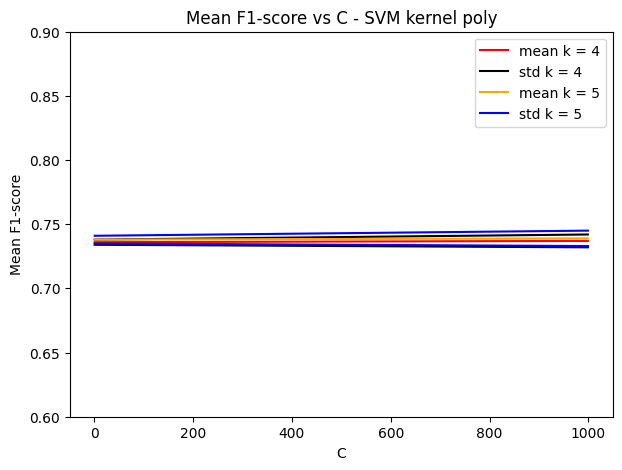

Modelo: kernel RBF y C = 1
K = 4: 0.783 +- 0.005
K = 5: 0.783 +- 0.010
Modelo: kernel RBF y C = 999
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012


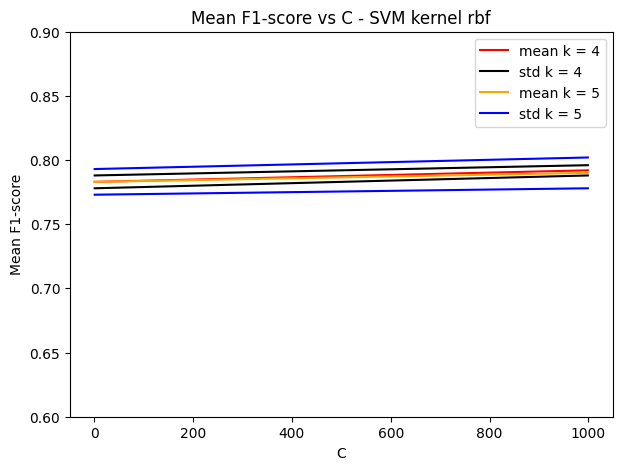

Modelo: kernel SIGMOID y C = 1
K = 4: 0.782 +- 0.011
K = 5: 0.782 +- 0.014
Modelo: kernel SIGMOID y C = 999
K = 4: 0.674 +- 0.015
K = 5: 0.686 +- 0.029


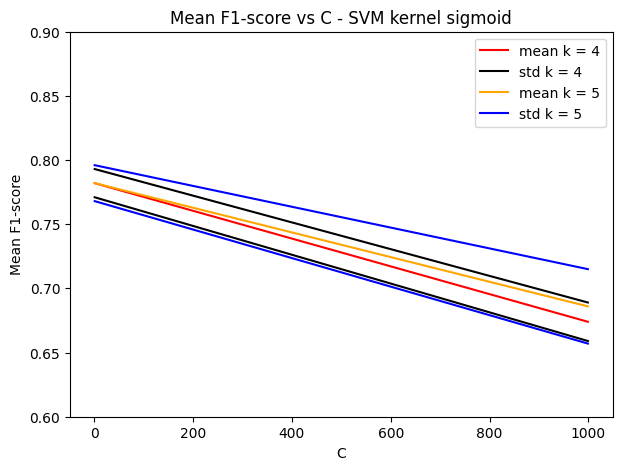

In [19]:
C_values = range(1, 1000, 998)

for tipo in ['linear', 'poly', 'rbf', 'sigmoid']:
    
    lista_resultados = [] # Lista con 2 mean y 2 std, uno para cada valor de k.
    
    for c in C_values:
        print(f"Modelo: kernel {tipo.upper()} y C = {c}")
            
        SVM = SVC(C = c, kernel = tipo, random_state = 8) # Creando modelo
        resultados = kfold(SVM) # Entrenando
        
        lista_resultados.append(resultados)

    graficar(lista_resultados, C_values, str(f'Mean F1-score vs C - SVM kernel {tipo}'), str('Mean F1-score'), str('C'), 0.6, 0.9, 7, 5)
 

#### Kernel poly para ambos C tuvo el f1-score más bajo así que se descarta.
#### Luego, tanto linear como sigmoid empeoraron su rendimiento con un C alto, de esto se infiere que los kernel no son adecados para aprender el set de datos.
#### Finalmente, kernel rbf cumple con el dilema sesgo-varianza. Además, para cada C los resultados son similares, si bien la diferencia de data no es extremadamente significativa, porque solo se está cambiando K, da a entender que al repetir el modelo la predicción no varía en gran medida, es decir, es e kernel que más generaliza.

### Por lo tanto, ahora se probará kernel radiobasal con distintos valores de C.

Modelo: kernel RBF y C = 0.1


K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001
Modelo: kernel RBF y C = 1
K = 4: 0.783 +- 0.005
K = 5: 0.783 +- 0.010
Modelo: kernel RBF y C = 2
K = 4: 0.792 +- 0.003
K = 5: 0.788 +- 0.010
Modelo: kernel RBF y C = 10
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 70
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 500
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 999
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012


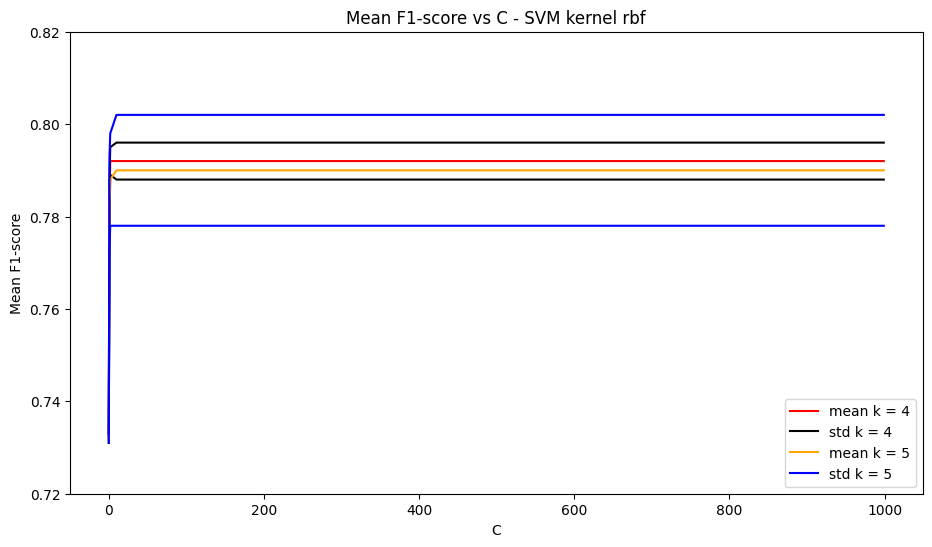

In [20]:
C_values = [0.1, 1, 2, 10, 70, 500, 999]

lista_resultados = []
for c in C_values:
    print(f"Modelo: kernel RBF y C = {c}")

    SVM = SVC(C = c, kernel = 'rbf', random_state = 8) # Creando modelo
    resultados = kfold(SVM) # Entrenando
    
    lista_resultados.append(resultados)
    
graficar(lista_resultados, C_values, str(f'Mean F1-score vs C - SVM kernel rbf'), str('Mean F1-score'), str('C'), 0.72, 0.82, 11, 6)
 


### Como se observa, luego de C = 10 el score se estabiliza, así que se analizará 1 <= C < 10:

Modelo: kernel RBF y C = 1


K = 4: 0.783 +- 0.005
K = 5: 0.783 +- 0.010
Modelo: kernel RBF y C = 2
K = 4: 0.792 +- 0.003
K = 5: 0.788 +- 0.010
Modelo: kernel RBF y C = 3
K = 4: 0.793 +- 0.004
K = 5: 0.792 +- 0.013
Modelo: kernel RBF y C = 4
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 5
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 6
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 7
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 8
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012
Modelo: kernel RBF y C = 9
K = 4: 0.792 +- 0.004
K = 5: 0.790 +- 0.012


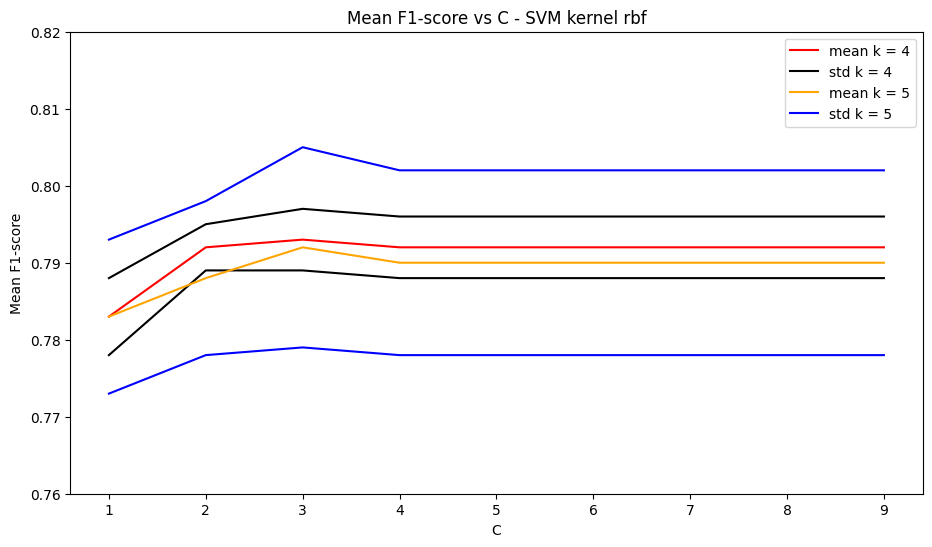

In [21]:
C_values = range(1,10,1)

lista_resultados = []
for c in C_values:
    print(f"Modelo: kernel RBF y C = {c}")

    SVM = SVC(C = c, kernel = 'rbf', random_state = 8) # Creando modelo
    resultados = kfold(SVM) # Entrenando
    
    lista_resultados.append(resultados)
    
graficar(lista_resultados, C_values, str(f'Mean F1-score vs C - SVM kernel rbf'), str('Mean F1-score'), str('C'), 0.76, 0.82, 11, 6)
 


### Finalmente, se escoge C = 3, ya que es el que menos variación de score entre los distintos k. No se considera std en la toma de decisión ya que es similiar entre todos.

## SVC(C = 3, kernel = 'rbf', random_state = 8)
#### Modelo: kernel RBF y C = 3
#### K = 4: 0.793 +- 0.004
#### K = 5: 0.792 +- 0.013

# Naive Bayes
### Se entrenarán modelos de NB con distintos valores de alpha:

Modelo: alpha = 0.1
K = 4: 0.793 +- 0.006
K = 5: 0.788 +- 0.011

Modelo: alpha = 0.5
K = 4: 0.791 +- 0.009
K = 5: 0.792 +- 0.010

Modelo: alpha = 1
K = 4: 0.774 +- 0.004
K = 5: 0.778 +- 0.008

Modelo: alpha = 2
K = 4: 0.750 +- 0.003
K = 5: 0.753 +- 0.004

Modelo: alpha = 5
K = 4: 0.738 +- 0.003
K = 5: 0.738 +- 0.003

Modelo: alpha = 10
K = 4: 0.734 +- 0.001
K = 5: 0.734 +- 0.002

Modelo: alpha = 60
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: alpha = 100
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001



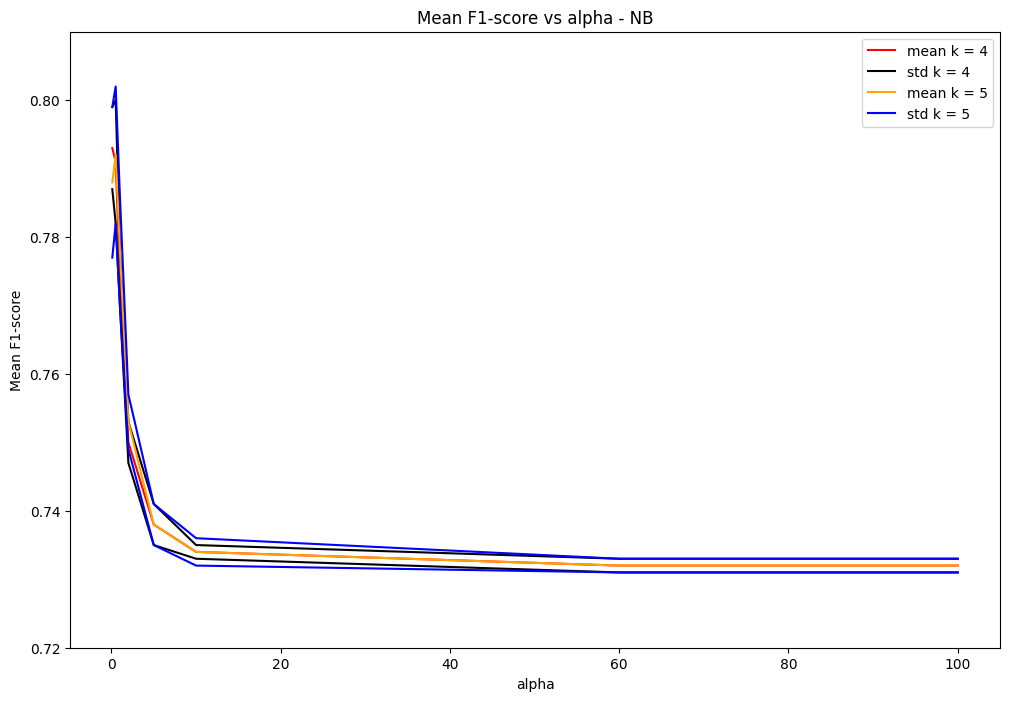

In [22]:
alpha_values = [0.1, 0.5, 1, 2, 5, 10, 60, 100]
lista_resultados = []

for alpha in alpha_values:
    print(f"Modelo: alpha = {alpha}")
        
    NB = MultinomialNB(alpha = alpha) # Creando modelo
    resultados = kfold(NB) # Entrenando
    print('')
    
    lista_resultados.append(resultados)
    
graficar(lista_resultados, alpha_values, str(f'Mean F1-score vs alpha - NB'), str('Mean F1-score'), str('alpha'), 0.72, 0.81, 12, 8)
 
    


### Se estabiliza luego de alpha = 2, por lo que se evalúa entre 0.1 y 2.

Modelo: alpha = 0.1
K = 4: 0.793 +- 0.006
K = 5: 0.788 +- 0.011

Modelo: alpha = 0.2
K = 4: 0.798 +- 0.008
K = 5: 0.788 +- 0.010

Modelo: alpha = 0.3
K = 4: 0.797 +- 0.011
K = 5: 0.791 +- 0.009

Modelo: alpha = 0.4
K = 4: 0.795 +- 0.011
K = 5: 0.793 +- 0.012

Modelo: alpha = 0.5
K = 4: 0.791 +- 0.009
K = 5: 0.792 +- 0.010

Modelo: alpha = 0.6
K = 4: 0.788 +- 0.012
K = 5: 0.788 +- 0.014

Modelo: alpha = 0.7
K = 4: 0.788 +- 0.011
K = 5: 0.785 +- 0.014

Modelo: alpha = 0.8
K = 4: 0.784 +- 0.010
K = 5: 0.783 +- 0.011

Modelo: alpha = 0.9
K = 4: 0.778 +- 0.006
K = 5: 0.782 +- 0.010

Modelo: alpha = 1.0
K = 4: 0.774 +- 0.004
K = 5: 0.778 +- 0.008

Modelo: alpha = 1.1
K = 4: 0.772 +- 0.003
K = 5: 0.773 +- 0.007

Modelo: alpha = 1.2
K = 4: 0.767 +- 0.002
K = 5: 0.770 +- 0.007

Modelo: alpha = 1.3
K = 4: 0.763 +- 0.002
K = 5: 0.767 +- 0.007

Modelo: alpha = 1.4
K = 4: 0.760 +- 0.002
K = 5: 0.762 +- 0.006

Modelo: alpha = 1.5
K = 4: 0.758 +- 0.003
K = 5: 0.759 +- 0.006

Modelo: alpha = 1.6
K = 4

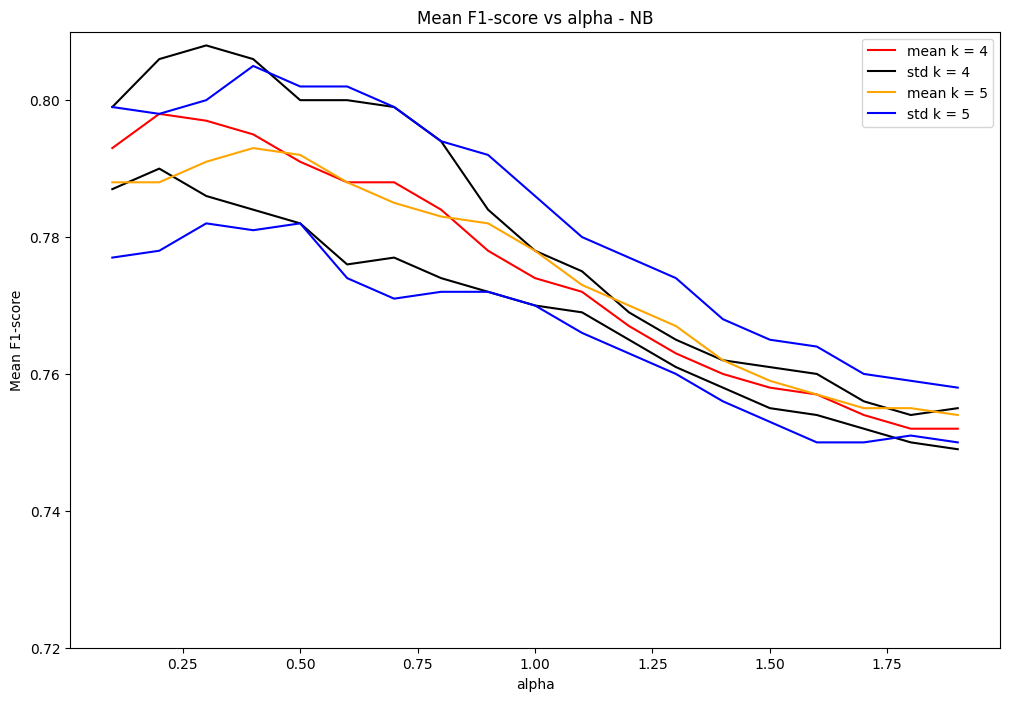

In [23]:
alpha_values =  range(1, 20, 1)
lista_resultados = []

for alpha in alpha_values:
    alpha = alpha / 10
    print(f"Modelo: alpha = {alpha}")
        
    NB = MultinomialNB(alpha = alpha)
    resultados =  kfold(NB)  # Entrenando
            
    print('')
    lista_resultados.append(resultados)

graficar(lista_resultados, [x/10 for x in alpha_values], str(f'Mean F1-score vs alpha - NB'), str('Mean F1-score'), str('alpha'), 0.72, 0.81, 12, 8)
 
    

    

In [24]:
# Concluir
# Hmm los que tienen score alto (bajo sesgo) igual tiene alta varianza
# alpha = 0.8 o 0.5 me convencen. Porque los score son altos, parecidos entre los k y 
# la std es como media, ni tan alta ni tan baja

# Ensamblados

## Bagging Random Forest
### Para escoger el mejor modelo, primero se va a elegir si usar gini o entropy como criterio. Para esto no se va a definir un max_depth de crecimiento, es decir, se tendrá un modelo complejo. La idea es que a mayor NE disminuya la varianza.

Modelo: GINI, NE = 20
K = 4: 0.768 +- 0.019
K = 5: 0.755 +- 0.009

Modelo: GINI, NE = 50
K = 4: 0.771 +- 0.020
K = 5: 0.770 +- 0.014

Modelo: GINI, NE = 100
K = 4: 0.780 +- 0.014
K = 5: 0.783 +- 0.012

Modelo: GINI, NE = 250
K = 4: 0.786 +- 0.013
K = 5: 0.787 +- 0.014

Modelo: GINI, NE = 500
K = 4: 0.786 +- 0.014
K = 5: 0.789 +- 0.015



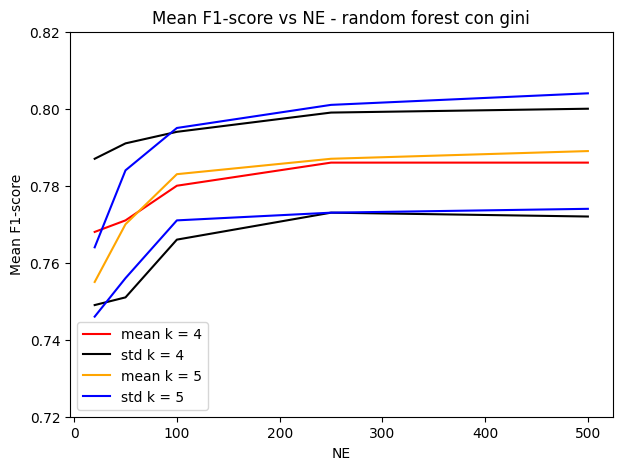

Modelo: ENTROPY, NE = 20
K = 4: 0.760 +- 0.008
K = 5: 0.773 +- 0.012

Modelo: ENTROPY, NE = 50
K = 4: 0.777 +- 0.007
K = 5: 0.787 +- 0.012

Modelo: ENTROPY, NE = 100
K = 4: 0.788 +- 0.012
K = 5: 0.789 +- 0.017

Modelo: ENTROPY, NE = 250
K = 4: 0.790 +- 0.011
K = 5: 0.794 +- 0.019

Modelo: ENTROPY, NE = 500
K = 4: 0.789 +- 0.010
K = 5: 0.795 +- 0.021



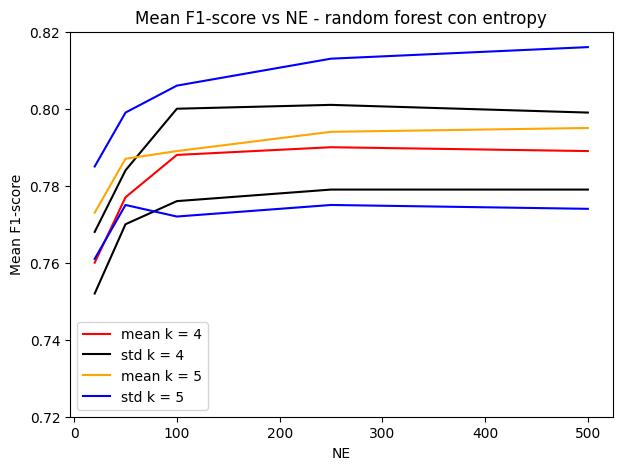

In [25]:
NE_values = [20, 50, 100, 250, 500]

for criterio in ['gini', 'entropy']:
    lista_resultados = []
    
    for NE in NE_values:
        print(f'Modelo: {criterio.upper()}, NE = {NE}')
        
        RFC = RandomForestClassifier(n_estimators = NE, criterion = criterio, n_jobs=-1, random_state=8) 
        resultados = kfold(RFC) 
        
        print('')
        
        lista_resultados.append(resultados)

    graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - random forest con {criterio}'), str('Mean F1-score'), str('NE'), 0.72, 0.82, 7, 5)
 

### Es posible notar que gini tiene valores menores de std y obtiene modelos más generalizados. Además, con entropy la std aumenta a medida que aumenta NE. Ahora se define la cantidad de árboles a usar (NE):

Modelo: NE = 5


K = 4: 0.750 +- 0.021
K = 5: 0.734 +- 0.009

Modelo: NE = 10
K = 4: 0.753 +- 0.009
K = 5: 0.731 +- 0.015

Modelo: NE = 20
K = 4: 0.768 +- 0.019
K = 5: 0.755 +- 0.009

Modelo: NE = 50
K = 4: 0.771 +- 0.020
K = 5: 0.770 +- 0.014

Modelo: NE = 100
K = 4: 0.780 +- 0.014
K = 5: 0.783 +- 0.012

Modelo: NE = 250
K = 4: 0.786 +- 0.013
K = 5: 0.787 +- 0.014

Modelo: NE = 500
K = 4: 0.786 +- 0.014
K = 5: 0.789 +- 0.015



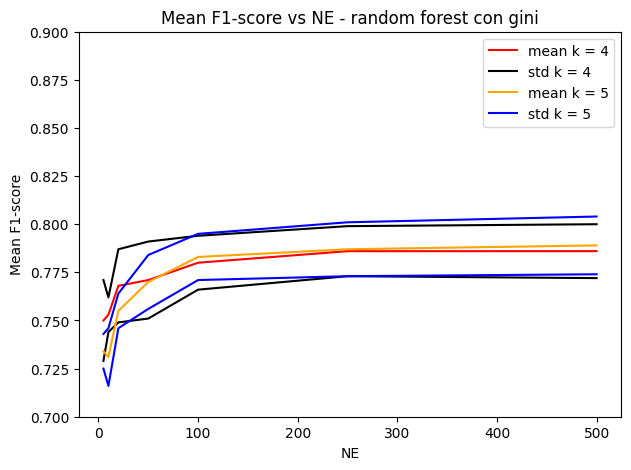

In [26]:
# AJUSTAR NE
#[20, 50, 100, 250, 500]

NE_values = [5, 10, 20, 50, 100, 250, 500]
lista_resultados = []

for NE in [5, 10, 20, 50, 100, 250, 500]:
    print(f'Modelo: NE = {NE}')
    
    RFC = RandomForestClassifier(n_estimators = NE, max_depth = None, criterion = 'gini', n_jobs=-1, random_state = 8)
    resultados = kfold(RFC)

    print('')
     
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - random forest con gini'), str('Mean F1-score'), str('NE'), 0.7, 0.9, 7, 5)
 
    





In [27]:
# Yo me quedo con 250

Modelo: MD = 2
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: MD = 4
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: MD = 6
K = 4: 0.733 +- 0.002
K = 5: 0.732 +- 0.001

Modelo: MD = 8
K = 4: 0.738 +- 0.004
K = 5: 0.736 +- 0.003

Modelo: MD = 10
K = 4: 0.741 +- 0.004
K = 5: 0.743 +- 0.002

Modelo: MD = 12
K = 4: 0.747 +- 0.003
K = 5: 0.747 +- 0.003

Modelo: MD = 14
K = 4: 0.751 +- 0.005
K = 5: 0.750 +- 0.008

Modelo: MD = 16
K = 4: 0.758 +- 0.002
K = 5: 0.757 +- 0.006

Modelo: MD = 18
K = 4: 0.757 +- 0.003
K = 5: 0.757 +- 0.007

Modelo: MD = 20
K = 4: 0.764 +- 0.007
K = 5: 0.768 +- 0.005

Modelo: MD = 22
K = 4: 0.768 +- 0.008
K = 5: 0.770 +- 0.006

Modelo: MD = 24
K = 4: 0.770 +- 0.008
K = 5: 0.773 +- 0.006

Modelo: MD = 26
K = 4: 0.777 +- 0.004
K = 5: 0.774 +- 0.005

Modelo: MD = 28
K = 4: 0.782 +- 0.008
K = 5: 0.776 +- 0.007



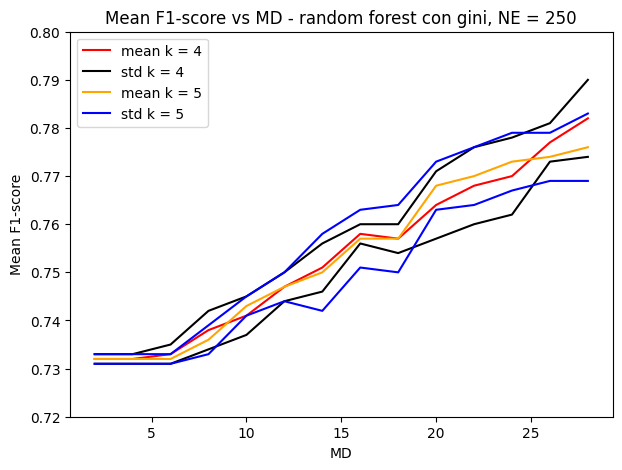

In [28]:
# AJUSTAR MAX DEPTH

MD_values = range(2, 30, 2)
lista_resultados = []

for MD in MD_values:
    print(f'Modelo: MD = {MD}')
                                            # Usando el 250
    RFC = RandomForestClassifier(n_estimators = 250, max_depth = MD, criterion = 'gini', n_jobs=-1, random_state = 8)
    resultados = kfold(RFC)

    print('')
     
    lista_resultados.append(resultados)

graficar(lista_resultados, MD_values, str(f'Mean F1-score vs MD - random forest con gini, NE = 250'), str('Mean F1-score'), str('MD'), 0.72, 0.8, 7, 5)
 

In [29]:
# yo me quedo con 12 - 18, aunque los scores son malísimos xd
# Aunque diría que los descarto, como que arbol mucho no le viene al set de datos

## Bagging de NV

Modelo: NE = 5
K = 4: 0.784 +- 0.010
K = 5: 0.789 +- 0.007

Modelo: NE = 10
K = 4: 0.789 +- 0.008
K = 5: 0.788 +- 0.012

Modelo: NE = 20
K = 4: 0.789 +- 0.008
K = 5: 0.794 +- 0.010

Modelo: NE = 50
K = 4: 0.792 +- 0.008
K = 5: 0.791 +- 0.010

Modelo: NE = 70
K = 4: 0.793 +- 0.009
K = 5: 0.790 +- 0.010

Modelo: NE = 100
K = 4: 0.791 +- 0.009
K = 5: 0.790 +- 0.011

Modelo: NE = 250
K = 4: 0.791 +- 0.011
K = 5: 0.790 +- 0.012

Modelo: NE = 500
K = 4: 0.792 +- 0.010
K = 5: 0.790 +- 0.011



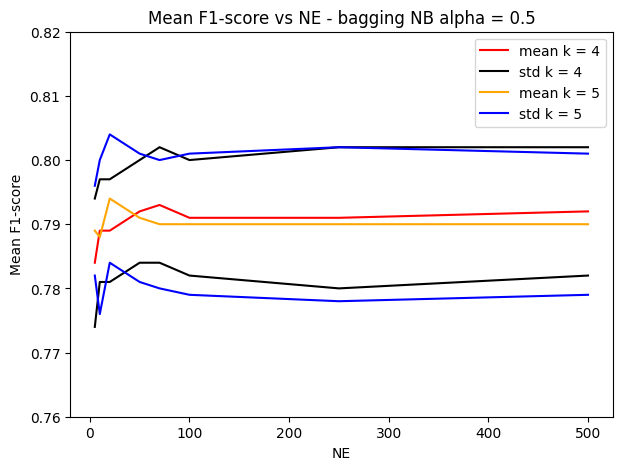

In [31]:
# AJUSTAR ALPHA Y NE 0.5
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    
    print(f'Modelo: NE = {NE}')
    
    BC = BaggingClassifier(estimator = MultinomialNB(alpha = 0.5), n_estimators = NE, random_state = 8)
    resultados = kfold(BC)
    
    print('')
     
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - bagging NB alpha = 0.5'), str('Mean F1-score'), str('NE'), 0.76, 0.82, 7, 5)
 

In [32]:
# se supone que el bagging disminuye la varianza pero no veo mucho cambio, 
# ni entre distinto NE o con el NB solito de antes. Así que tb lo descartaría

## Bagging de SVM

Modelo: NE = 5
K = 4: 0.783 +- 0.008
K = 5: 0.789 +- 0.006

Modelo: NE = 10
K = 4: 0.787 +- 0.003
K = 5: 0.787 +- 0.004

Modelo: NE = 20
K = 4: 0.789 +- 0.004
K = 5: 0.788 +- 0.006

Modelo: NE = 50
K = 4: 0.792 +- 0.007
K = 5: 0.789 +- 0.009

Modelo: NE = 70
K = 4: 0.794 +- 0.008
K = 5: 0.787 +- 0.008

Modelo: NE = 100
K = 4: 0.791 +- 0.007
K = 5: 0.790 +- 0.008

Modelo: NE = 250
K = 4: 0.790 +- 0.007
K = 5: 0.790 +- 0.008

Modelo: NE = 500
K = 4: 0.790 +- 0.007
K = 5: 0.789 +- 0.007



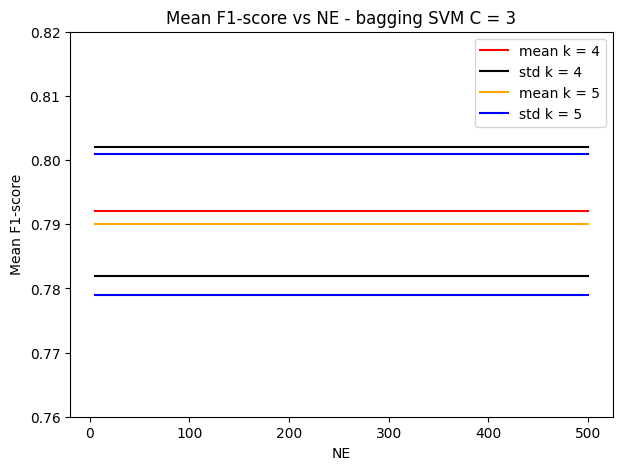

In [33]:
# AJUSTAR NE
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    
    BC = BaggingClassifier(estimator = SVC(C = 3, kernel = 'rbf', random_state = 8), n_estimators = NE, n_jobs=-1, random_state = 8)
    kfold(BC)

    
    print('')
    
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - bagging SVM C = 3'), str('Mean F1-score'), str('NE'), 0.76, 0.82, 7, 5)
 

In [ ]:
Estos son los resultados con SVM solito.
Modelo: kernel RBF y C = 3
K = 4: 0.793 +- 0.004
K = 5: 0.792 +- 0.013
    
# Se espera que la std baje y puede que ocurrir que el score baje tb (tipo baja varianza a costa 
# del sesgo que aumenta

# Yo diría NE = 10 aunque el NE = 100 tampoco se ve tan mal¿? No igual usa un montón de modelos 
# para empeorar la std y mejorar casi que nada el score. El NE = 20 se ve lindo igual. 
# Los 2 son 0.78 al final

## Adaboost

In [ ]:
# Este usa modelos sencillos y mejora el sesgo

Modelo: NE = 5
K = 4: 0.753 +- 0.018
K = 5: 0.758 +- 0.007

Modelo: NE = 10
K = 4: 0.737 +- 0.012
K = 5: 0.749 +- 0.017

Modelo: NE = 20
K = 4: 0.734 +- 0.017
K = 5: 0.745 +- 0.019

Modelo: NE = 50
K = 4: 0.715 +- 0.023
K = 5: 0.731 +- 0.020

Modelo: NE = 70
K = 4: 0.716 +- 0.014
K = 5: 0.724 +- 0.015

Modelo: NE = 100
K = 4: 0.734 +- 0.006
K = 5: 0.738 +- 0.015

Modelo: NE = 250
K = 4: 0.758 +- 0.010
K = 5: 0.761 +- 0.015

Modelo: NE = 500
K = 4: 0.758 +- 0.010
K = 5: 0.762 +- 0.015



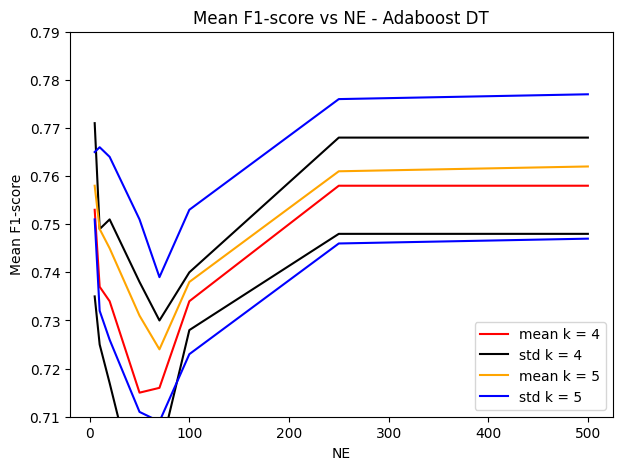

In [17]:
# AJUSTAR MD, NE 
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
                                                         # max_depth pequeño para que sea sencillo
    ABC = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = NE, random_state=8)
    resultados = kfold(ABC)
    print('')
    
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - Adaboost DT'), str('Mean F1-score'), str('NE'), 0.71, 0.79, 7, 5)
 

Modelo: NE = 5
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 10
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 20
K = 4: 0.731 +- 0.002
K = 5: 0.731 +- 0.003

Modelo: NE = 50
K = 4: 0.740 +- 0.005
K = 5: 0.736 +- 0.005

Modelo: NE = 70
K = 4: 0.743 +- 0.002
K = 5: 0.744 +- 0.005

Modelo: NE = 100
K = 4: 0.757 +- 0.004
K = 5: 0.754 +- 0.008

Modelo: NE = 250
K = 4: 0.778 +- 0.003
K = 5: 0.780 +- 0.012

Modelo: NE = 500
K = 4: 0.787 +- 0.005
K = 5: 0.787 +- 0.007



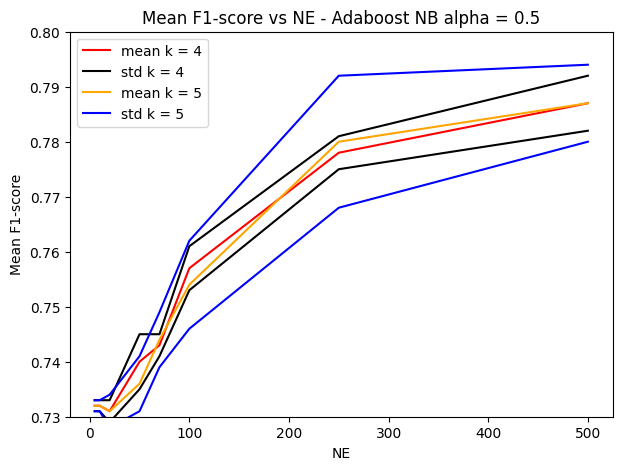

In [18]:
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
                                                        # Usando el 0.5. Cambiar de ser necesario
    ABC = AdaBoostClassifier(estimator = MultinomialNB(alpha = 0.5), n_estimators = NE, random_state=8)
    resultados = kfold(ABC)
    print('')
    
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - Adaboost NB alpha = 0.5'), str('Mean F1-score'), str('NE'), 0.73, 0.80, 7, 5)
 

Modelo: NE = 5
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 10
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 20
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 50
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 70
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 100
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 250
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001

Modelo: NE = 500
K = 4: 0.732 +- 0.001
K = 5: 0.732 +- 0.001



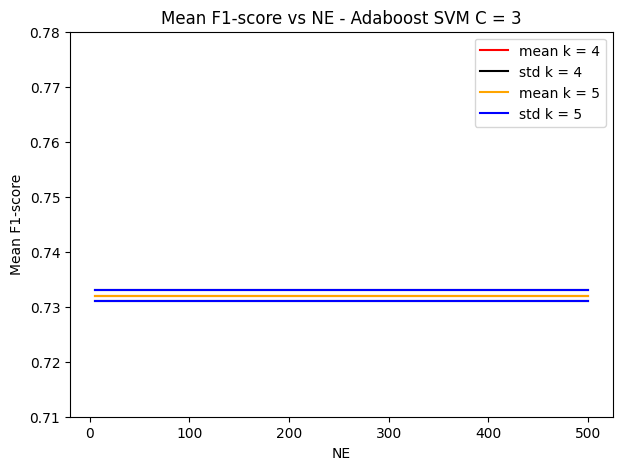

In [19]:
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
    
    ABC = AdaBoostClassifier(estimator=SVC(C=3, kernel='rbf', random_state=8), n_estimators=NE, algorithm='SAMME', random_state=8)
    
    resultados = kfold(ABC)
    print('')
    
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - Adaboost SVM C = 3'), str('Mean F1-score'), str('NE'), 0.71, 0.78, 7, 5)
 

## Gradient Boosting

Modelo: NE = 5
K = 4: 0.735 +- 0.003
K = 5: 0.733 +- 0.003

Modelo: NE = 10
K = 4: 0.754 +- 0.011
K = 5: 0.749 +- 0.013

Modelo: NE = 20
K = 4: 0.767 +- 0.011
K = 5: 0.764 +- 0.009

Modelo: NE = 50
K = 4: 0.775 +- 0.017
K = 5: 0.777 +- 0.014

Modelo: NE = 70
K = 4: 0.775 +- 0.011
K = 5: 0.784 +- 0.019

Modelo: NE = 100
K = 4: 0.777 +- 0.013
K = 5: 0.782 +- 0.013

Modelo: NE = 250
K = 4: 0.776 +- 0.009
K = 5: 0.784 +- 0.010

Modelo: NE = 500
K = 4: 0.779 +- 0.010
K = 5: 0.779 +- 0.009



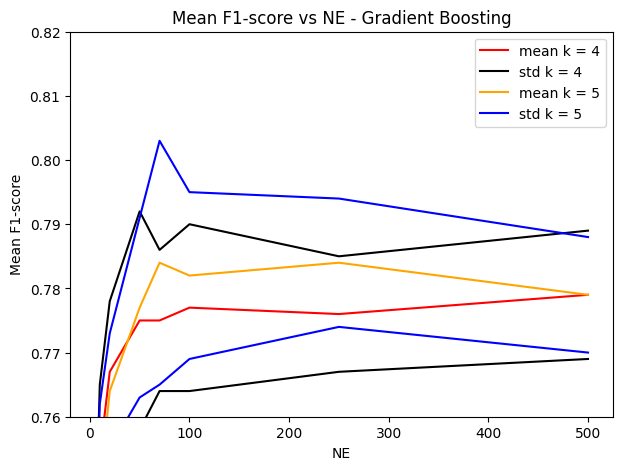

In [42]:


    
NE_values = [5, 10, 20, 50, 70, 100, 250, 500]
lista_resultados = []

for NE in NE_values:
    print(f'Modelo: NE = {NE}')
                                    
    GB = GradientBoostingClassifier(n_estimators = NE, random_state = 8)
    resultados = kfold(GB)
    print('')
    
    lista_resultados.append(resultados)

graficar(lista_resultados, NE_values, str(f'Mean F1-score vs NE - Gradient Boosting'), str('Mean F1-score'), str('NE'), 0.76, 0.82, 7, 5)
 
